# Gauss + Canny + Houghlines Estimator

## Pipeline, estimator, and results

This notebook shows how we build the Gauss + Canny + Houghlines estimator.
It also shows its performance on the validation and test set.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import random
import lib

In [2]:
X_val, y_val, X_test, y_test = lib.load_dataset("../dataset", rgb=False)

In [3]:
def show_image(img, to_rgb=True):
    if to_rgb:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        rgb = img
    plt.imshow(rgb,interpolation='nearest')
    plt.show()

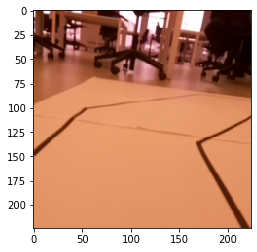

In [4]:
show_image(X_val[200])

In [5]:
class Config:
    def __init__(self, *args, **kwargs):
        self._d = kwargs
    def __getattr__(self, name):
        return self._d[name]

In [6]:
config = Config(
    gaussian_blur_kernel_size=(7, 7),
    gaussian_blur_sigma_x=1,
    top_offset_pct=0.25,
    canny_threshold1=190,
    canny_threshold2=250,
    houghlines_threshold=50,
)

In [7]:
def get_line_color_code(theta):
    b, g, r = 0, 0, 0
    # towards left: red
    if theta > np.pi/2:
        r = 255
    # towards right: blue
    else:
        b = 255
    return b, g, r

In [8]:
from math import isclose

def preprocess(img, show=False):
    """
    Get the edges from an image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if show:
        show_image(gray)
        
    blur = cv2.GaussianBlur(gray, config.gaussian_blur_kernel_size, config.gaussian_blur_sigma_x)
    if show:
        show_image(blur)

    height, width = blur.shape
    offset = int(height * config.top_offset_pct)
    blur_bottom = blur[offset:height,:]
    if show:
        show_image(blur_bottom)
    
    edges = cv2.Canny(blur_bottom, config.canny_threshold1, config.canny_threshold2)
    if show:
        show_image(edges)
    
    return edges

def get_lines(img, preprocess=preprocess, show=False):
    """
    Get lines from image with Hough transform
    """
    if show:
        show_image(img)
        
    offset = int(img.shape[0] * config.top_offset_pct)
    edges = preprocess(img, show=show)
   
    lines = lib.detect_lines_parametric(edges, config.houghlines_threshold)
    
    img_lines = lib.draw_lines_parametric(img, lines, offset=offset, color_func=get_line_color_code)
    
    if show:
        show_image(img_lines)
            
    return lines, img_lines

In [9]:
begin = time.time()
get_lines(X_val[200])
end = time.time()
print(f"get_lines took {end-begin:.3}s")

get_lines took 0.00369s


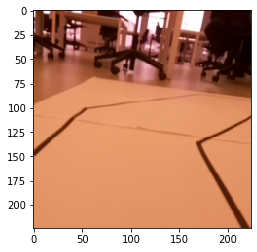

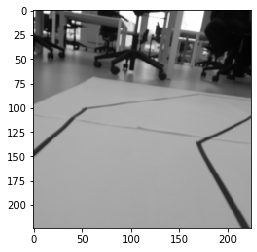

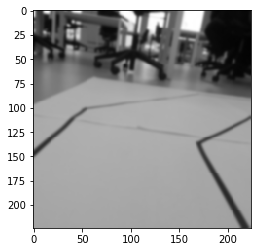

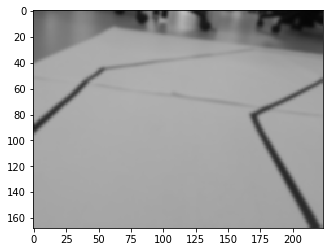

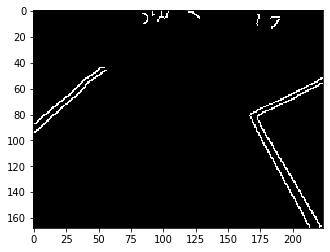

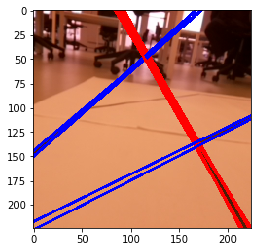

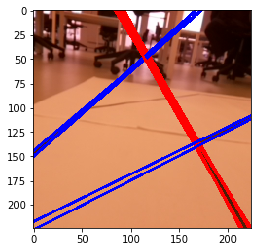

In [10]:
show_image(get_lines(X_val[200], show=True)[1])

In [11]:
img_set = [X_val[i] for i in range(0, 4000, 150)]

In [12]:
img_lines_set = [get_lines(img)[1] for img in img_set]

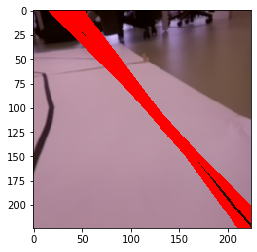

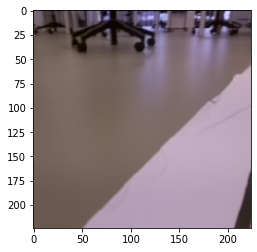

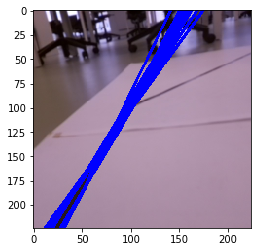

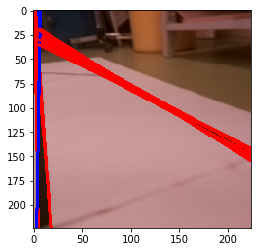

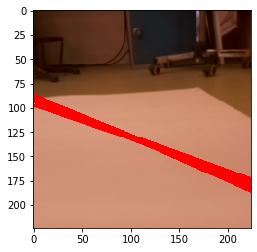

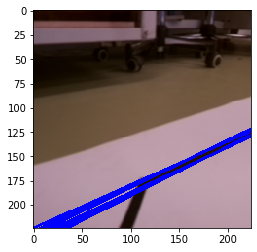

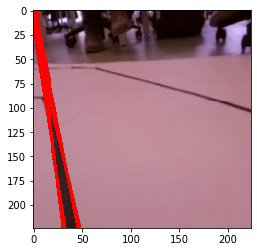

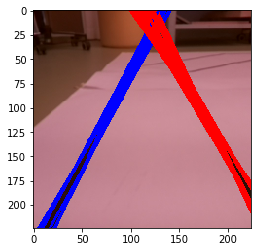

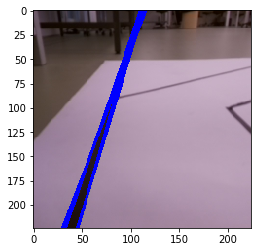

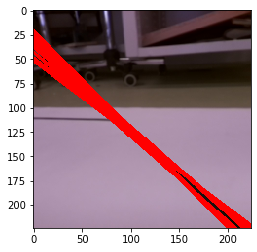

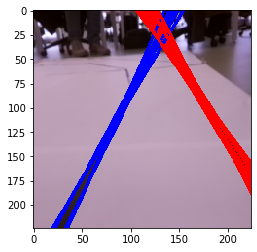

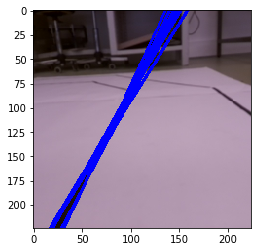

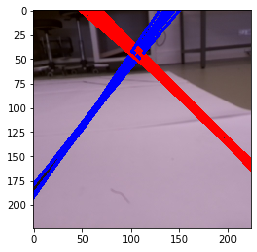

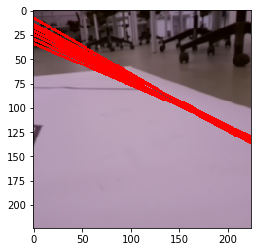

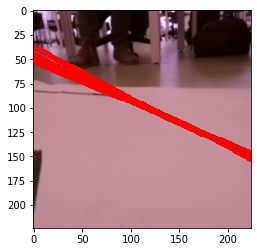

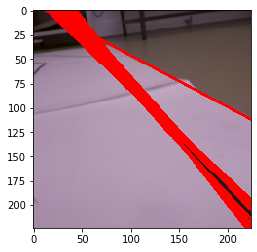

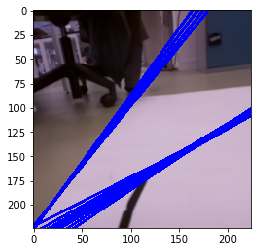

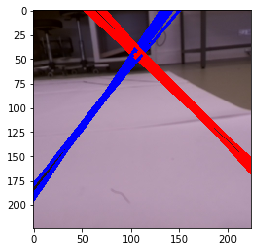

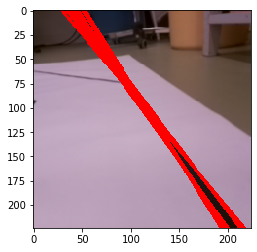

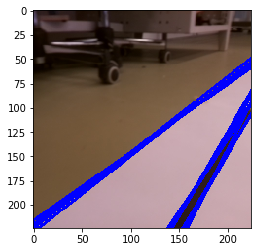

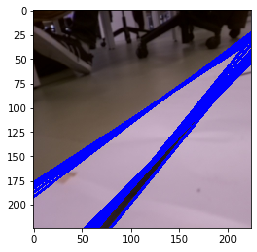

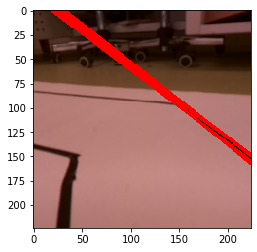

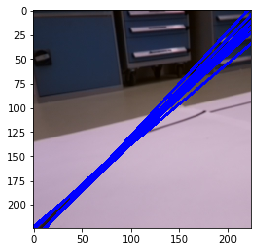

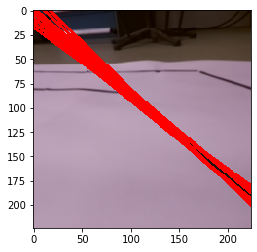

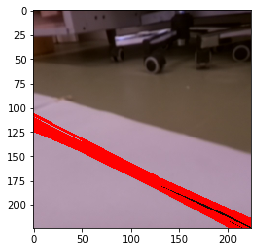

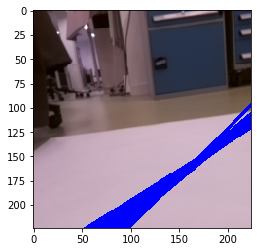

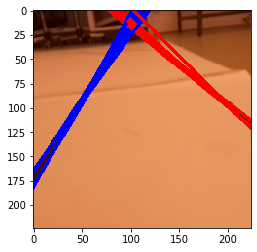

In [13]:
for img_lines in img_lines_set:
    show_image(img_lines)

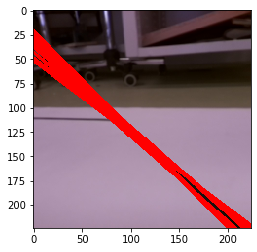

In [14]:
lines, img_lines = get_lines(X_val[1350])
show_image(img_lines)

In [15]:
def get_direction(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return math.sin(np.mean(right))#/(np.pi/2)
    elif not right:
        return math.sin(-np.mean(left))#/(np.pi/2)
    else:
        return 0

In [16]:
def stick_to_labels(get_direction):
    def f(lines):
        if get_direction(lines) < -0.75:
            return -1
        elif get_direction(lines) < -0.25:
            return -0.5
        elif get_direction(lines) < 0.25:
            return 0
        elif get_direction(lines) < 0.75:
            return 0.5
        return 1
    return f

In [17]:
get_direction(lines)

-0.7499186815192924

In [18]:
class GaussCannyHoughlinesEstimator(lib.Estimator):
    def __init__(self, get_lines, get_direction):
        self.get_lines = get_lines
        self.get_direction = get_direction
    
    def predict_one(self, img):
        return self.get_direction(self.get_lines(img)[0])

In [19]:
GaussCannyHoughlinesEstimator(get_lines, get_direction).score(X_val, y_val)

(0.1949310643715525, 0.33096032125408664)

In [20]:
GaussCannyHoughlinesEstimator(get_lines, get_direction).score(X_test, y_test)

(0.206647331654426, 0.34170839052216656)

In [21]:
GaussCannyHoughlinesEstimator(get_lines, stick_to_labels(get_direction)).score(X_val, y_val)

(0.2126943117672601, 0.3252496743378202)

In [22]:
class ZeroEstimator(lib.Estimator):
    def predict_one(self, img):
        return 0

In [23]:
print(ZeroEstimator().score(X_val, y_val))

(0.5003300043421623, 0.5913590968302215)


In [24]:
print(ZeroEstimator().score(X_test, y_test))

(0.5173611111111112, 0.6111111111111112)


In [25]:
class RandomEstimator(lib.Estimator):
    def predict_one(self, img):
        return 2*random.random()-1

In [26]:
print(RandomEstimator().score(X_val, y_val))

(0.8416090302073909, 0.7560077583010596)


In [27]:
print(RandomEstimator().score(X_test, y_test))

(0.8550815572750448, 0.7623478842625778)


In [28]:
grid = {
    "gaussian_blur_kernel_size": [(7, 7)],
    "gaussian_blur_sigma_x": [1],
    "top_offset_pct": [0.25],
    "canny_threshold1": [170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220],
    "canny_threshold2": [250],
    "houghlines_threshold": [50],
}

In [29]:
from itertools import product

def grid_search(grid, X, y):
    results = {}
    try:
        keys = grid.keys()
        grid_prod = list(product(*grid.values()))
        start = time.time()
        estimator = GaussCannyHoughlinesEstimator(get_lines, get_direction)
        for idx, values in enumerate(grid_prod):
            d = dict(zip(keys, values))
            global config
            config = Config(**d)
            results[tuple(values)] = estimator.score(X, y)
            print(f"\rIteration {idx+1}/{len(grid_prod)}, time since start: {time.time()-start}, results: {results[tuple(values)]}", end="")
    except Exception as e:
        print(f"\nException caught: {e}")
        return results
    print("\nEnd")
    return results

In [30]:
results = grid_search(grid, X_val, y_val)

Iteration 11/11, time since start: 60.886637449264526, results: (0.2004758613220311, 0.3371714856718762))
End


In [31]:
import pprint

pprint.pprint(results)

{((7, 7), 1, 0.25, 170, 250, 50): (0.1962068119124592, 0.33183014393558785),
 ((7, 7), 1, 0.25, 175, 250, 50): (0.19611356315868878, 0.3320594458553365),
 ((7, 7), 1, 0.25, 180, 250, 50): (0.19632951601574608, 0.3324831454850462),
 ((7, 7), 1, 0.25, 185, 250, 50): (0.19618066407793133, 0.3324063800041861),
 ((7, 7), 1, 0.25, 190, 250, 50): (0.1949310643715525, 0.33096032125408664),
 ((7, 7), 1, 0.25, 195, 250, 50): (0.1948034910470533, 0.33092579464056304),
 ((7, 7), 1, 0.25, 200, 250, 50): (0.19528583060733307, 0.33156828911214725),
 ((7, 7), 1, 0.25, 205, 250, 50): (0.19623727311769623, 0.3325778740324265),
 ((7, 7), 1, 0.25, 210, 250, 50): (0.19767345965517696, 0.33419691228545045),
 ((7, 7), 1, 0.25, 215, 250, 50): (0.19791784606244792, 0.33467800948911003),
 ((7, 7), 1, 0.25, 220, 250, 50): (0.2004758613220311, 0.3371714856718762)}


In [32]:
print(min([(k, v) for k, v in results.items()], key=lambda x: x[1][0]))
print(min([(k, v) for k, v in results.items()], key=lambda x: x[1][1]))
print(min([(k, v) for k, v in results.items()], key=lambda x: x[1][0]+x[1][1]))

(((7, 7), 1, 0.25, 195, 250, 50), (0.1948034910470533, 0.33092579464056304))
(((7, 7), 1, 0.25, 195, 250, 50), (0.1948034910470533, 0.33092579464056304))
(((7, 7), 1, 0.25, 195, 250, 50), (0.1948034910470533, 0.33092579464056304))


In [33]:
illustration_pics = [
    "pic197_238",
    "pic584_72",
    "pic857_622",
]
illustration_imgs = [cv2.imread("../illustrations/"+src+".jpg") for src in illustration_pics]

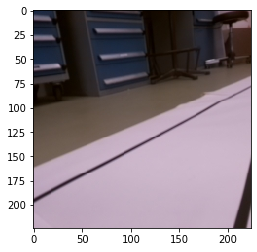

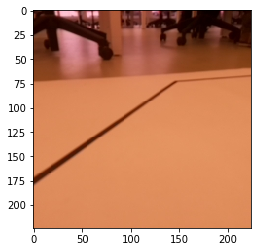

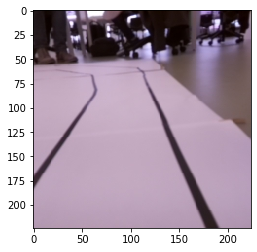

In [34]:
for img in illustration_imgs:
    show_image(img)

In [35]:
illustration_gaussian = [
    cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), config.gaussian_blur_kernel_size, config.gaussian_blur_sigma_x)
    for img in illustration_imgs
]

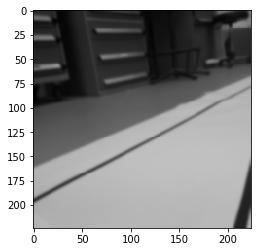

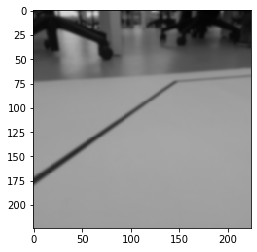

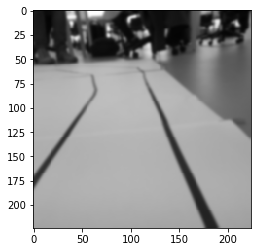

In [36]:
for img in illustration_gaussian:
    show_image(img)

In [37]:
# for src, img in zip(illustration_pics, illustration_gaussian):
#     cv2.imwrite("../illustrations/"+src+"_gaussian.jpg", img)

In [38]:
illustration_canny = [
    cv2.Canny(img, config.canny_threshold1, config.canny_threshold2)
    for img in illustration_gaussian
]

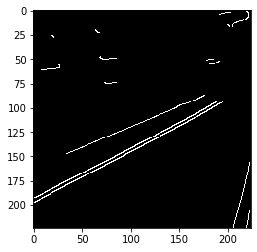

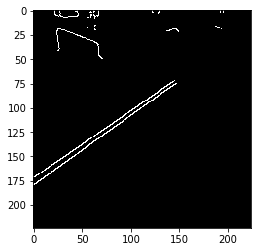

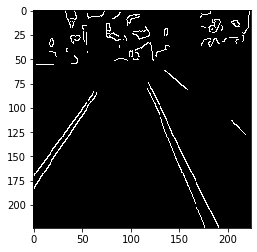

In [39]:
for img in illustration_canny:
    show_image(img)

In [40]:
# for src, img in zip(illustration_pics, illustration_canny):
#     cv2.imwrite("../illustrations/"+src+"_canny.jpg", img)

In [41]:
def bottom(img):
    height, width = img.shape
    offset = int(height * config.top_offset_pct)
    return img[offset:height,:]

illustration_canny_cropped = [
    cv2.Canny(bottom(img), config.canny_threshold1, config.canny_threshold2)
    for img in illustration_gaussian
]

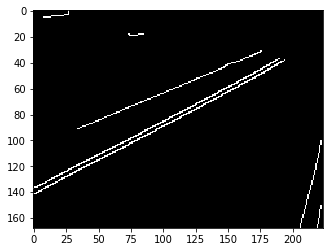

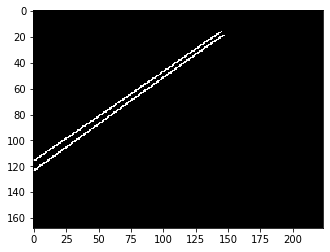

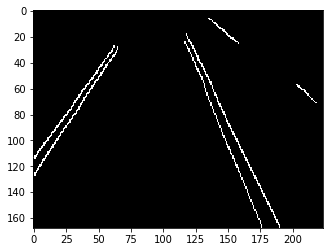

In [42]:
for img in illustration_canny_cropped:
    show_image(img)

In [43]:
# for src, img in zip(illustration_pics, illustration_canny_cropped):
#     cv2.imwrite("../illustrations/"+src+"_canny_cropped.jpg", img)

In [44]:
illustration_houghlines = [
    get_lines(img)[1]
    for img in illustration_imgs
]

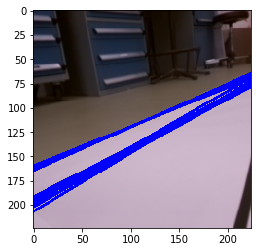

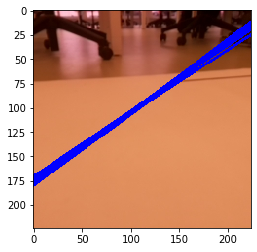

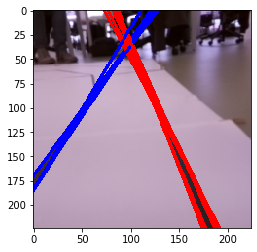

In [45]:
for img in illustration_houghlines:
    show_image(img)

In [46]:
# for src, img in zip(illustration_pics, illustration_houghlines):
#     cv2.imwrite("../illustrations/"+src+"_houghlines.jpg", img)

In [47]:
mini = float("inf")
maxi = -float("inf")
for _ in range(10000):
    begin = time.time()
    preprocess(illustration_imgs[0])
    end = time.time()
    ms_took = (end-begin)*1000
    if ms_took < mini:
        mini = ms_took
    if ms_took > maxi:
        maxi = ms_took
print(f"took {mini:.4f} to {maxi:.4f} ms")

took 0.1795 to 4.9682 ms


## Misc Experiments

This is some non-relevant code for old experiments.

In [48]:
def get_direction_threshold(threshold):
    def get_direction(lines):  
        if lines is None:
            return 0
        
        angles, _ = lib.lines_angles(lines)
        left_angles = [a for a in angles if a < 0]
        right_angles = [a for a in angles if a > 0]
        
        all_left = (angles < 0).all()
        all_right = (angles > 0).all()
                    
        # get direction from difference
        if len(angles) == 0: return 0
        elif all_left or all_right: return lib.normalize_angle(np.mean(angles))

        
        l_mean = np.mean(left_angles)
        r_mean = np.mean(right_angles)
        
        # l_mean is negative
        diff = - l_mean - r_mean
        if abs(diff) < threshold:
            return 0
        
        # Majority to the left
        if diff > 0:
            return lib.normalize_angle(np.mean(left_angles))
        
        # Else majority to the right
        return lib.normalize_angle(np.mean(right_angles))
    
    return get_direction

In [49]:
get_direction_threshold(5)(lines)

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
for threshold in [1, 3, 5, 7, 9, 11, 15, 17, 25]:
    print(ClassicHoughlinesEstimator(get_lines, get_direction_threshold(threshold)).score(X_val, y_val))

In [ ]:
def get_direction_mean(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return np.mean(right)/(np.pi/2)
    elif not right:
        return -np.mean(left)/(np.pi/2)
    else:
        return 0

In [ ]:
ClassicHoughlinesEstimator(get_lines, get_direction_mean).score(X_val, y_val)

In [ ]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction_mean)).score(X_val, y_val)

In [ ]:
def get_direction_max(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return np.max(right)/(np.pi/2)
    elif not right:
        return -np.max(left)/(np.pi/2)
    else:
        return 0

In [ ]:
ClassicHoughlinesEstimator(get_lines, get_direction_max).score(X_val, y_val)

In [ ]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction_max)).score(X_val, y_val)

In [ ]:
def get_direction_sin_max(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return math.sin(np.max(right))
    elif not right:
        return math.sin(-np.max(left))
    else:
        return 0

In [ ]:
ClassicHoughlinesEstimator(get_lines, get_direction_sin_max).score(X_val, y_val)

In [ ]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction_sin_max)).score(X_val, y_val)

In [ ]:
def get_direction_sin_mean(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return math.sin(np.mean(right))
    elif not right:
        return math.sin(-np.mean(left))
    else:
        return 0

In [ ]:
ClassicHoughlinesEstimator(get_lines, get_direction_sin_mean).score(X_val, y_val)

In [ ]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction_sin_mean)).score(X_val, y_val)